<a href="https://colab.research.google.com/github/isoittech/SAMPLE_WEB_pytorch_lstm/blob/master/mk_pytorch02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

PyTorchを使ってLSTMで文章分類を実装してみた。  
前の版ではPytorchでLSTMを使って文章分類（ニュース記事のタイトルのカテゴリ分類）を実装しました。  
その際、バッチ化はひとまず置いといて（バッチサイズ=1）で実装していましたが、今回はバッチ化対応した。

https://qiita.com/m__k/items/db1a81bb06607d5b0ec5

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import linecache
from IPython.display import Image
import re

try:
    try:
        import MeCab
    except ImportError:
        # MeCabをcolabで使えるようにする
        !apt install aptitude
        !aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
        !pip install mecab-python3
        import MeCab # 再挑戦
        !ln -s /etc/mecabrc /usr/local/etc/mecabrc
except ImportError as e:
  print('Mecab import error')
  print(e)



Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-l

# データ準備とバッチ化
LSTMのインプットの形式は前回の記事でも言及したように文章の長さ × バッチサイズ × ベクトル次元数の３次元テンソルでした。

実際のデータ（ニュース記事のタイトル）の長さ（厳密には形態素の数）は異なりますが、データをバッチ化してまとめてLSTMに流すために文章の系列の長さを揃える必要があります。

系列の長さを揃えるために単語リストに新しく<pad>（単語ID＝0）を追加して短い文章を0パディングします。
詳細はソースコードを見たほうがわかりやすいと思うので、いきなり全ソースを載せつつ、前回の記事と比べてバッチ化対応するために変更した部分に言及してきます。

In [2]:
if os.path.exists('text'):
  print('Directory text exists.')
else:
  try:
    try:
      from google.colab import drive
      drive.mount(r'/content/drive')
      %cd '/content/drive/MyDrive/Colab Notebooks/SAMPLES/pytorch_lstm'
      %pwd
      # %ls
      !tar xvf ldcc-20140209.tar.gz
      %ls

    except Exception as e1:
      print('Maybe you not Google Colab.')
      print(e1)

  except Exception as e2:
    print('Error')
    print(e2)

ストリーミング出力は最後の 5000 行に切り捨てられました。
text/smax/smax-6833494.txt
text/smax/smax-6833579.txt
text/smax/smax-6834422.txt
text/smax/smax-6834562.txt
text/smax/smax-6834765.txt
text/smax/smax-6834990.txt
text/smax/smax-6835318.txt
text/smax/smax-6838218.txt
text/smax/smax-6838260.txt
text/smax/smax-6838332.txt
text/smax/smax-6838453.txt
text/smax/smax-6838514.txt
text/smax/smax-6838627.txt
text/smax/smax-6838702.txt
text/smax/smax-6842164.txt
text/smax/smax-6842219.txt
text/smax/smax-6842269.txt
text/smax/smax-6842402.txt
text/smax/smax-6842629.txt
text/smax/smax-6842882.txt
text/smax/smax-6843206.txt
text/smax/smax-6845003.txt
text/smax/smax-6847081.txt
text/smax/smax-6849018.txt
text/smax/smax-6850114.txt
text/smax/smax-6850391.txt
text/smax/smax-6850789.txt
text/smax/smax-6851590.txt
text/smax/smax-6851919.txt
text/smax/smax-6853063.txt
text/smax/smax-6853346.txt
text/smax/smax-6853751.txt
text/smax/smax-6854198.txt
text/smax/smax-6855347.txt
text/smax/smax-6855946.txt
text/smax/smax-6856195.

In [3]:
# カテゴリを配列で取得
categories = [name for name in os.listdir("text") if os.path.isdir("text/" + name)]
print(categories)

['dokujo-tsushin', 'livedoor-homme', 'kaden-channel', 'smax', 'peachy', 'movie-enter', 'it-life-hack', 'sports-watch', 'topic-news']


In [4]:
datasets = pd.DataFrame(columns=["title", "category"])
print(f"type: ${type(datasets)}")
print(f"shape: ${datasets.shape}")
datasets

type: $<class 'pandas.core.frame.DataFrame'>
shape: $(0, 2)


,title,category


In [5]:
for cat in categories:
    path = "text/" + cat + "/*.txt"
    files = glob(path)
    for text_name in files:
        title = linecache.getline(text_name, 3)
        s = pd.Series([title, cat], index=datasets.columns)
        datasets = datasets.append(s, ignore_index=True)

print(f"type: ${type(datasets)}")
print(f"shape: ${datasets.shape}")
datasets

type: $<class 'pandas.core.frame.DataFrame'>
shape: $(7376, 2)


,title,category
0,日本←→韓国ドラマのリメイク作品、どう思う？\n,dokujo-tsushin
1,男を「疲れさせる女」の正体とは!?\n,dokujo-tsushin
2,女性たちが望む快適空間とは？\n,dokujo-tsushin
3,現役ホステスに聞く、一番人気のホステスとは？\n,dokujo-tsushin
4,ネットで断ち切れない元カレとの縁\n,dokujo-tsushin
...,...,...
7371,台湾警察がパンツ丸見えの“うしじまいい肉”に激怒\n,topic-news
7372,ピザの起源は“韓国”とするCMが話題に\n,topic-news
7373,少女時代ジェシカに日本人が「悪魔」とアダ名をつけた？\n,topic-news
7374,支援を受ける立場なのに態度が大きい韓国紙\n,topic-news


## 形態素解析エンジン定義


In [6]:
tagger = MeCab.Tagger("-Owakati")

def make_wakati(sentence):
    sentence = tagger.parse(sentence)
    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
    wakati = sentence.split(" ")
    wakati = list(filter(("").__ne__, wakati))
    return wakati

## 単語IDの辞書を定義
単語IDの辞書に新しく\<pad\>を追加

In [7]:
word2index = {}
# 系列を揃えるためのパディング文字列<pad>を追加
# パディング文字列のIDは0とする
word2index.update({"<pad>":0})

for title in datasets["title"]:
    wakati = make_wakati(title)
    for word in wakati:
        if word in word2index: continue
        word2index[word] = len(word2index)
print("vocab size : ", len(word2index))

vocab size :  13230


## 系列の長さを揃えてバッチでまとめる


In [8]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

cat2index = {}
for cat in categories:
    if cat in cat2index: continue
    cat2index[cat] = len(cat2index)
    
cat2index

{'dokujo-tsushin': 0,
 'it-life-hack': 6,
 'kaden-channel': 2,
 'livedoor-homme': 1,
 'movie-enter': 5,
 'peachy': 4,
 'smax': 3,
 'sports-watch': 7,
 'topic-news': 8}

In [9]:
def sentence2index(sentence):
    wakati = make_wakati(sentence)
    return [word2index[w] for w in wakati]

def category2index(cat):
    return [cat2index[cat]]

In [10]:
index_datasets_title_tmp = []
index_datasets_category = []

# 系列の長さの最大値を取得。この長さに他の系列の長さをあわせる
max_len = 0
for title, category in zip(datasets["title"], datasets["category"]):
  index_title = sentence2index(title)
  index_category = category2index(category)
  index_datasets_title_tmp.append(index_title)
  index_datasets_category.append(index_category)
  if max_len < len(index_title):
    max_len = len(index_title)

print(type(index_datasets_title_tmp))
index_datasets_title_tmp[:10]

<class 'list'>


[[1, 2, 3, 4, 5, 6, 7, 8],
 [9, 10, 11, 12, 13, 4, 14, 15, 16],
 [17, 18, 19, 20, 21, 22, 15, 16],
 [23, 24, 25, 26, 27, 28, 4, 24, 15, 16],
 [29, 30, 31, 32, 33, 34, 15, 4, 35],
 [36, 37, 38, 39, 13, 25, 40, 41, 25, 42, 43, 44],
 [45, 46, 19, 47, 48, 4, 16, 49, 50],
 [17, 25, 51, 52, 53, 54, 55, 56, 57, 58, 59, 4, 60],
 [61, 37, 25, 51, 62, 10, 63, 25, 64, 65, 66, 67, 68, 16, 69],
 [70, 13, 18, 25, 71, 72, 73, 74, 75, 76, 7, 77]]

In [11]:
max_len

39

In [12]:
print(type(index_datasets_category))
index_datasets_category[:10]

<class 'list'>


[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]

In [13]:
# 系列の長さを揃えるために短い系列にパディングを追加
# 後ろパディングだと正しく学習できなかったので、前パディング
index_datasets_title = []
for title in index_datasets_title_tmp:
  for i in range(max_len - len(title)):
    title.insert(0, 0) # 前パディング
#     title.append(0)　# 後ろパディング
  index_datasets_title.append(title)

print(type(index_datasets_title))
index_datasets_title[:3]

<class 'list'>


[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  9,
  10,
  11,
  12,
  13,
  4,
  14,
  15,
  16],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  17,
  18,
  19,
  20,
  21,
  22,
  15,
  16]]

In [14]:
train_x, test_x, train_y, test_y = train_test_split(index_datasets_title, index_datasets_category, train_size=0.7)


In [15]:
# データをバッチでまとめるための関数
def train2batch(title, category, batch_size=100):
  title_batch = []
  category_batch = []
  title_shuffle, category_shuffle = shuffle(title, category)
  for i in range(0, len(title), batch_size):
    title_batch.append(title_shuffle[i:i+batch_size])
    category_batch.append(category_shuffle[i:i+batch_size])
  return title_batch, category_batch

## モデル定義
パディング文字列ももちろん埋め込む必要があるわけですが、\<pad>は0ベクトルで埋め込み、学習の妨げにならないようにする(?)ために、nn.Embedding()にてpadding_idx=0を追加しています。
LSTMを定義する際、batch_first=Trueを指定すると、LSTMのインプットの形式がバッチサイズ × 文章の長さ × ベクトル次元数になります。こうしたほうが次元を操作する際にわかりやすいと思います。

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# GPUを使うために必要
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
test_x = torch.zeros(2, 1, 3)
print(test_x.size())
test_x

torch.Size([2, 1, 3])


tensor([[[0., 0., 0.]],

        [[0., 0., 0.]]])

In [18]:
test_y = torch.squeeze(test_x)
print(test_y.size())
test_y

torch.Size([2, 3])


tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [19]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        # <pad>の単語IDが0なので、padding_idx=0としている
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # batch_first=Trueが大事！
        # batch_first=Trueを指定すると、LSTMのインプットの形式がバッチサイズ × 文章の長さ(vocab_size) × ベクトル次元数(embedding_dim)になる
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax()

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        # embeds.size() => (batch_size × len(sentence) × embedding_dim)
        _, lstm_out = self.lstm(embeds)
        # lstm_out[0].size() => (1 × batch_size × hidden_dim)
        # lstm_outには2個の要素がある。1つ目が最後の隠れ層の隠れ状態h、2つ目が最後の隠れ層のセル状態c。
        # many to one パターンであるため、最後の隠れ層の隠れ状態しか使わないので、lstm_out[0]のみを使う（結合層に渡す）。
        tag_space = self.hidden2tag(lstm_out[0])
        # tag_space.size() => (1 × batch_size × tagset_size)
        # (batch_size × tagset_size)にするためにsqueeze()してから（次元を落としてから）、softmax関数にかける。
        # https://pytorch.org/docs/stable/generated/torch.squeeze.html
        tag_scores = self.softmax(tag_space.squeeze())
        # tag_scores.size() = (batch_size × tagset_size)ｈ

        return tag_scores

In [20]:
# 単語の埋め込み次元数上げた。精度がそこそこアップ！ハイパーパラメータのチューニング大事。
EMBEDDING_DIM = 200
HIDDEN_DIM = 128
VOCAB_SIZE = len(word2index)
TAG_SIZE = len(categories)
# to(device)でモデルがGPU対応する
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAG_SIZE).to(device)
loss_function = nn.NLLLoss()
# SGDからAdamに変更。特に意味はなし
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 学習
1epoch毎に全バッチを学習させます。バッチごとに逆伝搬してパラメータ更新させてます。

In [21]:
losses = []
for epoch in range(100):
    all_loss = 0
    title_batch, category_batch = train2batch(train_x, train_y)
    for i in range(len(title_batch)):
        batch_loss = 0

        model.zero_grad()

        # 順伝搬させるtensorはGPUで処理させるためdevice=にGPUをセット
        title_tensor = torch.tensor(title_batch[i], device=device)
        # category_tensor.size() = (batch_size × 1)なので、squeeze()
        category_tensor = torch.tensor(category_batch[i], device=device).squeeze()

        out = model(title_tensor)

        batch_loss = loss_function(out, category_tensor)
        batch_loss.backward()
        optimizer.step()

        all_loss += batch_loss.item()
    losses.append(all_loss)
    print("epoch", epoch, "\t" , "loss", all_loss)
    if all_loss < 0.1: break
print("done.")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 	 loss 94.13061547279358
epoch 1 	 loss 62.761597990989685
epoch 2 	 loss 44.16298067569733
epoch 3 	 loss 29.90828537940979
epoch 4 	 loss 18.770905926823616
epoch 5 	 loss 10.67496371269226
epoch 6 	 loss 5.523094724863768
epoch 7 	 loss 3.002507897093892
epoch 8 	 loss 1.662538232281804
epoch 9 	 loss 1.0139864599332213
epoch 10 	 loss 0.7307207933627069
epoch 11 	 loss 0.5901203523389995
epoch 12 	 loss 0.49143507285043597
epoch 13 	 loss 0.42398621467873454
epoch 14 	 loss 0.36673175916075706
epoch 15 	 loss 0.3330478055868298
epoch 16 	 loss 0.31905370263848454
epoch 17 	 loss 0.2897811958100647
epoch 18 	 loss 0.2627645740285516
epoch 19 	 loss 0.252143997233361
epoch 20 	 loss 0.24593770573846996
epoch 21 	 loss 0.23366603208705783
epoch 22 	 loss 0.22677274147281423
epoch 23 	 loss 0.22121864353539422
epoch 24 	 loss 0.2110199781600386
epoch 25 	 loss 0.20489469764288515
epoch 26 	 loss 0.20086677389917895
epoch 27 	 loss 0.19664042996009812
epoch 28 	 loss 0.197403978

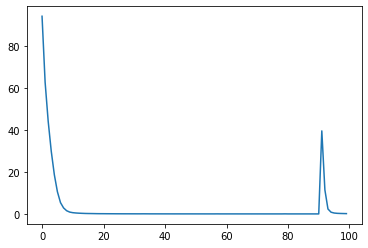

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)

## 予測
バッチ毎にまとめて予測。
前回と比べて精度が上がっているのは単語の埋め込み次元数を上げたからだと思われます。

In [26]:
test_num = len(test_x)
a = 0
with torch.no_grad():
    title_batch, category_batch = train2batch(test_x, test_y)

    for i in range(len(title_batch)):
        title_tensor = torch.tensor(title_batch[i], device=device)
        title_tensor = torch.tensor(title_tensor).to(device).long()
        print(title_tensor.size())
        category_tensor = torch.tensor(category_batch[i], device=device)
        
        out = model(title_tensor)
        _, predicts = torch.max(out, 1)
        for j, ans in enumerate(category_tensor):
            if predicts[j].item() == ans.item():
                a += 1
print("predict : ", a / test_num)

torch.Size([2, 1, 3])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


RuntimeError: ignored

## 最後に
バッチ化対応の一番苦労したところはやはり次元の扱いでした。私と同じように次元数によるエラーで躓いている方は、全てのtensorの次元を逐一確認して、データの形状を細かく追ってみるのがよいと思います。

In [27]:
!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.22
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
dlib==19.18.0
dm-tree==0.1.6
docopt==0.6.2
